# comparison of overlay with EventWeight to Beam-On data

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
import json
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/EventWeight/'

In [5]:
versions['overlay date'] = '2018_08_01'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'

path = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/'
prefix = path+versions['Overlay']+'_'+versions['overlay date']+'_'
selected_overlay=dict()

if os.path.isfile(prefix+'selected_cc1p0pi.csv'): 
    for pair_type in pair_types:
        selected_overlay[pair_type]=pd.read_csv(prefix+'selected_'+pair_type+'.csv')
    selected_overlay_concat = pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])    
    selected_CC1p0pi=pd.read_csv(prefix+'selected_cc1p0pi.csv')
    overlay_scaling = json.load(open(prefix+"overlay_scaling_POT.txt"))


else:
    OverlaySamples = load_samples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')
    cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
    reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order)
    print 'applied cuts to overlay'
    for pair_type in pair_types:
        selected_overlay[pair_type] = reducedOverlay['Pt & delta phi'][pair_type]
    selected_overlay_concat = pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])    
    print len(selected_overlay_concat),'events in the overlay'
    selected_cc1p0pi = selected_overlay['CC 1p 0pi']
    print len(selected_cc1p0pi),'selected CC 1p 0pi pairs in overlay'
    for pair_type in pair_types:
        selected_overlay[pair_type].to_csv(prefix+'selected_'+pair_type+'.csv')
    selected_cc1p0pi.to_csv(prefix+'selected_cc1p0pi.csv')
    print 'output to ',figures_path,'.csv'
    
    # overlay scaling
    summary = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/summary/'+versions['overlay date']+'/'+versions['Overlay']+'_'+versions['overlay date']+'_summary.csv')
    Nevents['OnBeam POT'] = 4.908e+19
    Nevents['overlay']      = np.sum(summary.Nevents)
    Nevents['overlay POT']  = np.sum(summary.POT)
    Nevents['f(POT)']       = Nevents['OnBeam POT']/Nevents['overlay POT']
    print "Nevents['f(POT)']:",Nevents['f(POT)']
    overlay_scaling = get_samples_scaling( N_total='MC(tot) x POT', debug=0, OverlaySubsamples=OverlaySamples, f_POT=Nevents['f(POT)'])
    filename = prefix+"overlay_scaling_POT.txt"
    json.dump(overlay_scaling, open(filename,'w'))
    print 'saved scaling into',filename

In [6]:
selected_events=pd.read_csv('/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/SelectedEvents/selected_events.csv')

# $Q^2$ distribution of the overlay events with different weights

### $Q^2$ distribution in the selected events

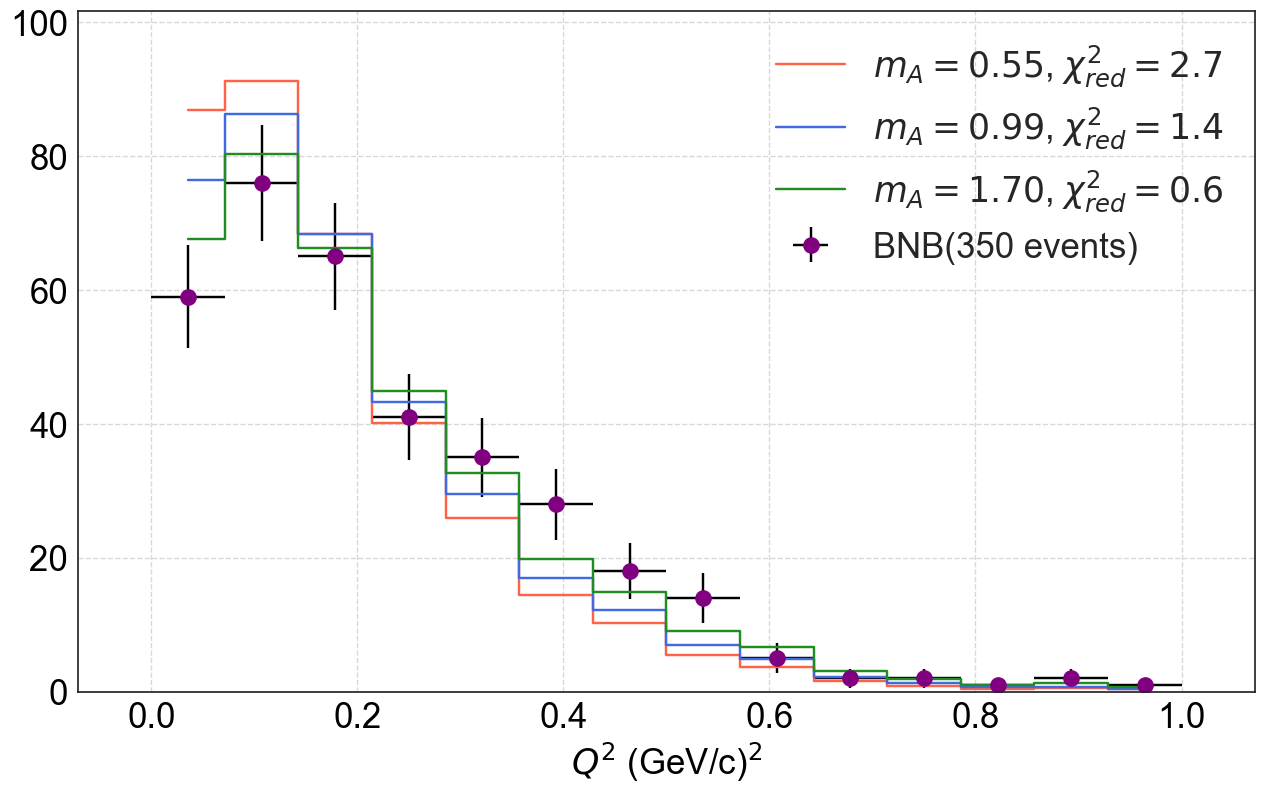

In [8]:
var,x_label = 'reco_Q2', r'$Q^2$ (GeV/c)$^2$'
bins = linspace(0,1,15); mid = 0.5*(bins[1:]+bins[:-1])
chi2_xrange = (0.,1)#(np.min(bins),np.max(bins))
fig=plt.figure(figsize=(12.944,8))
ax = fig.add_subplot(1,1,1)
data,mc = selected_events,selected_overlay
h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=data,color='purple',var=var, bins=bins, markersize=12, ax=ax, do_return_h=True)    

mA_array = [0.40,0.70,0.80,0.95,0.99,1.00,1.10,1.15,1.35,1.71]
for mA,color in zip( [0.55,0.99,1.7],['tomato','royalblue','forestgreen']):
    name = '%.0f'%(mA*100) 
    h_overlay,_ = np.histogram(selected_overlay_concat[var],bins=bins, weights=selected_overlay_concat['evwgh_mA'+name+'_Genie'])
    h_overlay_err = len(data)*np.sqrt(h_overlay)/np.sum(h_overlay)
    h_overlay = len(data)*h_overlay/np.sum(h_overlay)
#     h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc
#                                                    , norm=len(data), ax=ax
#                                                    , overlay_scaling=overlay_scaling
#                                                    , var=var
#                                                    , weights_var='evwgh_mA'+name+'_Genie', bins=bins
#                                                    , do_individual_histograms=False, stackColor=color
#                                                    , stackLabel=None)
    #plt.errorbar(x=mid, y=h_overlay,yerr=h_overlay_err,fmt='.',color=color)    
    if chi2_xrange is not None:
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
    plt.step( mid , h_overlay, where='mid',color=color, label='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.1f$'%(chi2/ndf))
set_axes(ax,x_label,'',do_add_grid=False,alpha_grid=1,ylim=(0,1.2*np.max(h_OnBeam+h_OnBeam_err))
         ,do_add_legend=True,legend_loc='upper right')

# ax = fig.add_subplot(1,2,2)
# chi2_red = []
# for mA,name in zip(mA_array,mA_names):
#     h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc
#                                                    , norm=len(data), do_draw=False
#                                                    , overlay_scaling=overlay_scaling
#                                                    , var=mcvar, weights_var='evwgh_mA'+name+'_Genie', bins=bins)
#     chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
#                                          , h1=h_OnBeam , h1err=h_OnBeam_err
#                                          , h2=h_overlay ,  h2err=h_overlay_err
#                                          , debug=0 if mA==0.4 else 0)
#     chi2_red.append(chi2/ndf)
# plt.errorbar(mA_array,chi2_red,fmt='ro',markersize=10)
# set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$\chi^2_{red.}$')
# plt.tight_layout()
# save_figure(figures_path+'Q2_EventWeight.pdf')

# what happens before the cuts, or before kinematical cuts?

In [ ]:
OverlaySamples = load_samples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')
cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order)
print 'applied cuts to overlay'

In [10]:
OnBeam = pd.concat([pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_04_'+versions['data date']+'_vertices.csv')
                    ,pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_05_'+versions['data date']+'_vertices.csv')])
OnBeamFV = sample_in_FV(OnBeam)
reducedOnBeam,BeamOnNumbers = apply_cuts_to_data(OnBeamFV=OnBeamFV,cuts_order=cuts_order)
print 'applied cuts to beam-on'


applied cuts to beam-on


In [13]:
cut_name = 'vertex activity'
for pair_type in pair_types:
    selected_overlay[pair_type] = reducedOverlay[cut_name][pair_type]
selected_overlay_concat = pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])    
selected_events = reducedOnBeam[cut_name]

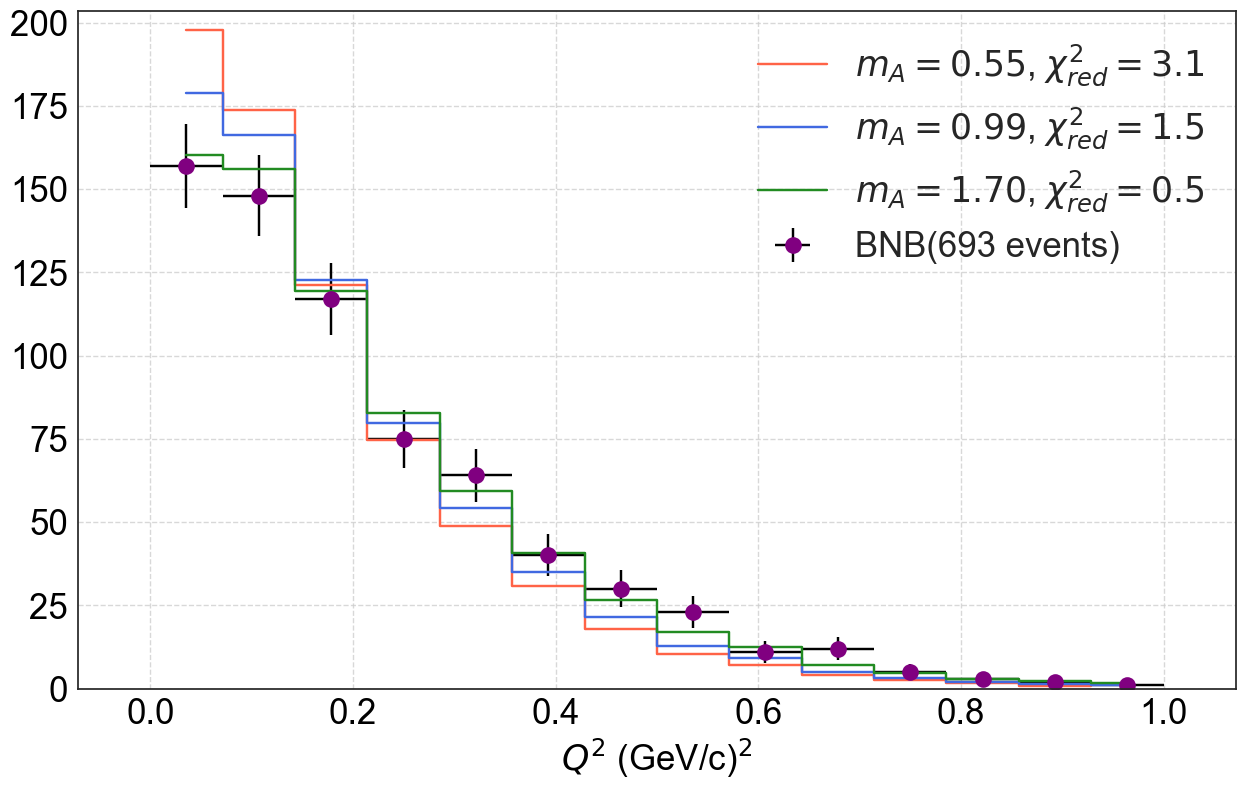

In [14]:
var,x_label = 'reco_Q2', r'$Q^2$ (GeV/c)$^2$'
bins = linspace(0,1,15); mid = 0.5*(bins[1:]+bins[:-1])
chi2_xrange = (0.,1)
fig=plt.figure(figsize=(12.944,8))
ax = fig.add_subplot(1,1,1)
data,mc = selected_events,selected_overlay
h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=data,color='purple',var=var, bins=bins, markersize=12, ax=ax, do_return_h=True)    

mA_array = [0.40,0.70,0.80,0.95,0.99,1.00,1.10,1.15,1.35,1.71]
for mA,color in zip( [0.55,0.99,1.7],['tomato','royalblue','forestgreen']):
    name = '%.0f'%(mA*100) 
    h_overlay,_ = np.histogram(selected_overlay_concat[var],bins=bins, weights=selected_overlay_concat['evwgh_mA'+name+'_Genie'])
    h_overlay_err = len(data)*np.sqrt(h_overlay)/np.sum(h_overlay)
    h_overlay = len(data)*h_overlay/np.sum(h_overlay)
    if chi2_xrange is not None:
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
    plt.step( mid , h_overlay, where='mid',color=color, label='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.1f$'%(chi2/ndf))
set_axes(ax,x_label,'',do_add_grid=False,alpha_grid=1,ylim=(0,1.2*np.max(h_OnBeam+h_OnBeam_err))
         ,do_add_legend=True,legend_loc='upper right')

# or maybe as a function of $p_p$

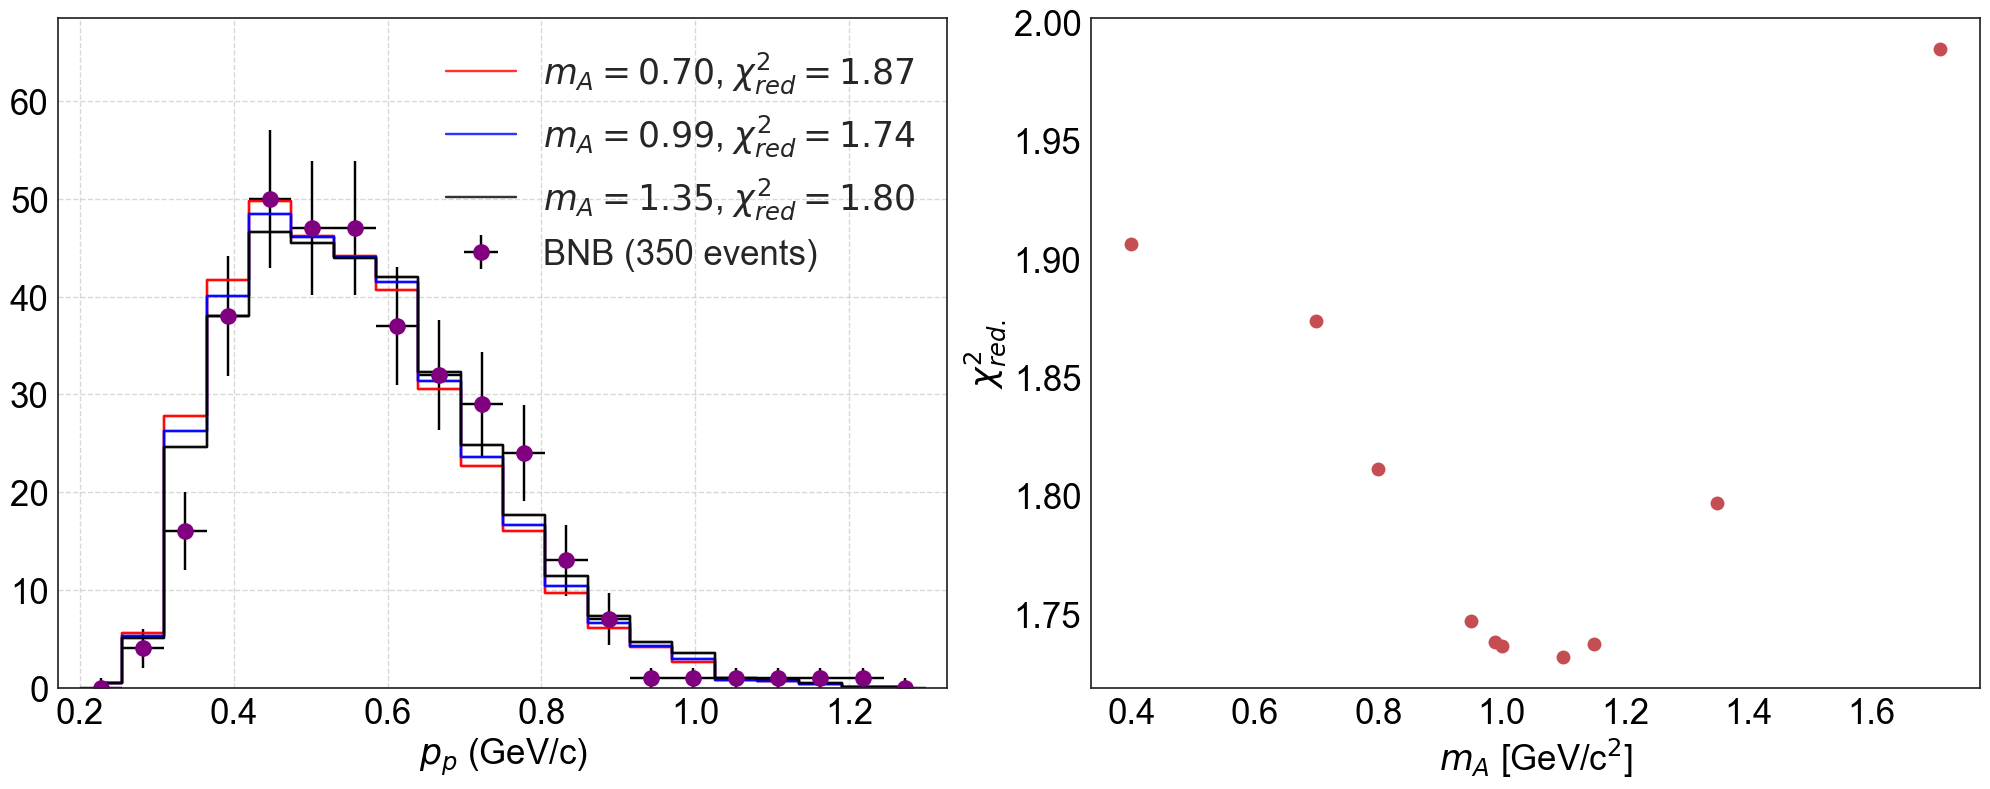

In [51]:
var = 'reco_Pp'
mcvar = 'truth_Pp'
x_label = r'$p_p$ (GeV/c)'
bins = linspace(0.2,1.3,21); mid = 0.5*(bins[1:]+bins[:-1])
chi2_xrange = (0.,1)#(np.min(bins),np.max(bins))

fig=plt.figure(figsize=(20,8))

ax = fig.add_subplot(1,2,1)
# data,mc = selected_events_tightFV,selected_overlay_tightFV
data,mc = selected_events,selected_overlay

h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=data,color='purple',var=var, bins=bins, markersize=12, ax=ax, do_return_h=True)    
mA_array = [0.40,0.70,0.80,0.95,0.99,1.00,1.10,1.15,1.35,1.71]
mA_names = ['040','070','080','095','099','100','110','115','135','171']
for mA,name,color in zip([0.7,0.99,1.35],['070','099','135'],['red','blue','black']):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc
                                                   , norm=len(data), ax=ax
                                                   , overlay_scaling=overlay_scaling
                                                   , var=mcvar
                                                   , weights_var='evwgh_mA'+name+'_Genie', bins=bins
                                                   , do_individual_histograms=False, stackColor=color
                                                   , stackLabel=None)
    if chi2_xrange is not None:
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
        h_overlay,_=plot_stacked_MCsamples( OverlaySamples=mc
                                           , norm=len(data), ax=ax
                                           , overlay_scaling=overlay_scaling
                                           , var=mcvar
                                           , weights_var='evwgh_mA'+name+'_Genie'
                                           , bins=bins, do_individual_histograms=False, stackColor=color
                                           ,stackLabel='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.2f$'%(chi2/ndf))
set_axes(ax,x_label,'',do_add_grid=False,alpha_grid=1,ylim=(0,1.2*np.max(h_OnBeam+h_OnBeam_err))
         ,do_add_legend=True,legend_loc='upper right')


ax = fig.add_subplot(1,2,2)
chi2_red = []
for mA,name in zip(mA_array,mA_names):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc
                                                   , norm=len(data), do_draw=False
                                                   , overlay_scaling=overlay_scaling
                                                   , var=mcvar, weights_var='evwgh_mA'+name+'_Genie', bins=bins)
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
    chi2_red.append(chi2/ndf)
plt.errorbar(mA_array,chi2_red,fmt='ro',markersize=10)
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$\chi^2_{red.}$')
plt.tight_layout()

In [22]:
var = 'reco_Pp'
x_label = r'reconstructed $p_p$ (GeV/c)'
bins = linspace(0.2,1.3,15); mid = 0.5*(bins[1:]+bins[:-1])

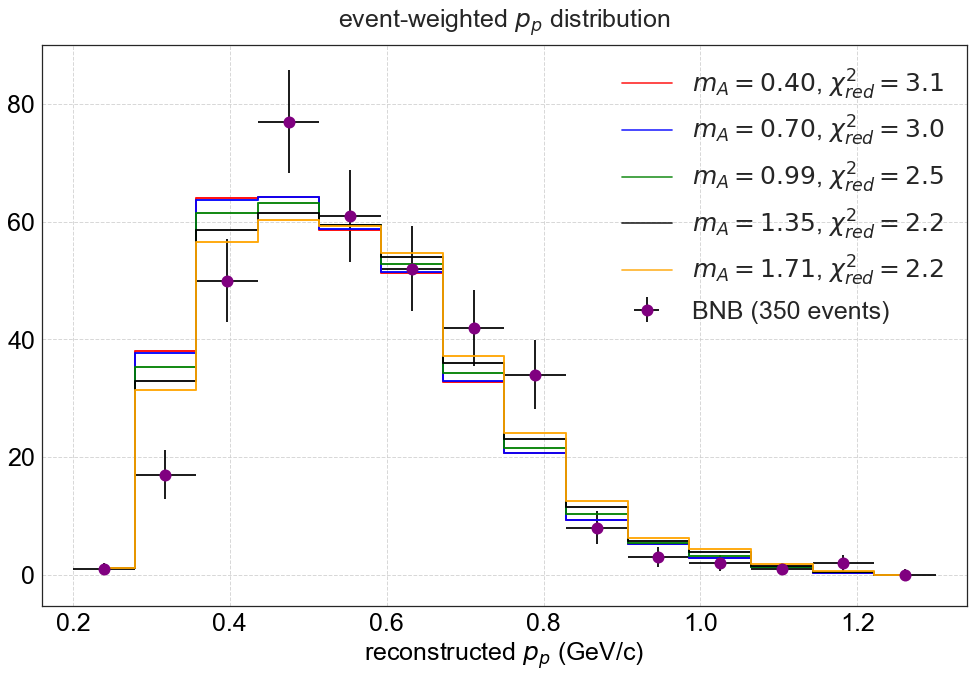

In [23]:
fig,ax=plt.subplots(figsize=(14,9))
h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=selected_events,color='purple'
                                      , var=var, bins=bins, markersize=12, ax=ax, do_return_h=True)    

for mA,name,color in zip([0.40,0.70,0.99,1.35,1.71]              
                         ,['040','070','099','135','171']
                         ,['red','blue','green','black','orange']):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=selected_overlay, norm=len(selected_events)
                           , ax=ax, overlay_scaling=overlay_scaling
                           , var=var, weights_var='evwgh_mA'+name+'_Genie'
                           , bins=bins, do_individual_histograms=False
                           , stackColor=color,stackLabel=None)
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=(np.min(bins),np.max(bins))
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err )
    h_overlay,_=plot_stacked_MCsamples( OverlaySamples=selected_overlay, norm=len(selected_events)
                           , ax=ax
                           , overlay_scaling=overlay_scaling
                           , var=var, weights_var='evwgh_mA'+name+'_Genie'
                           , bins=bins, do_individual_histograms=False, stackColor=color
                                       ,stackLabel='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.1f$'%(chi2/ndf))

set_axes(ax,x_label,'',do_add_grid=False,alpha_grid=1
         ,do_add_legend=True
         ,title='event-weighted $p_p$ distribution')
# save_figure(figures_path+'Q2_EventWeight.pdf')

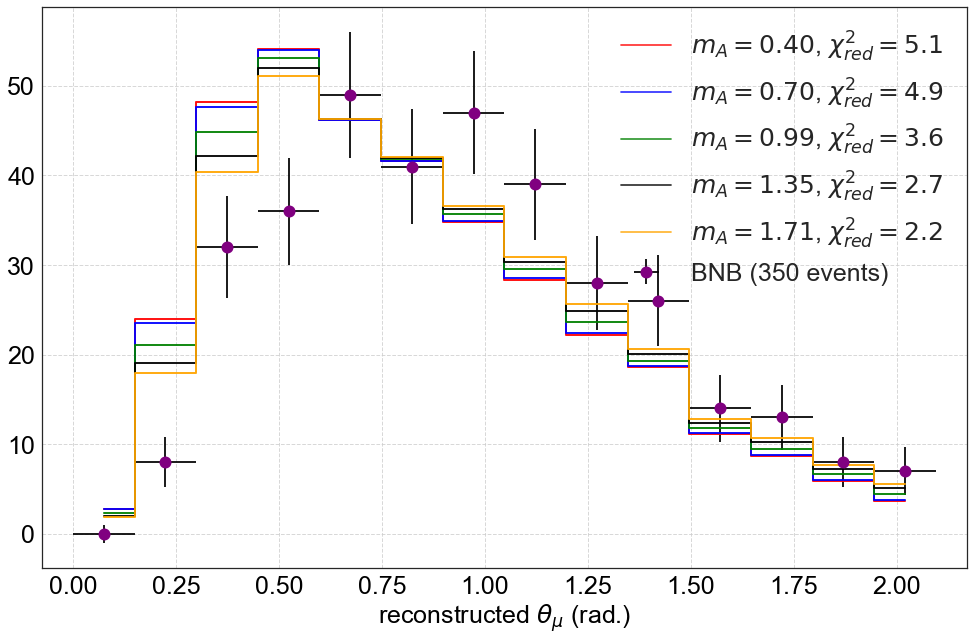

In [27]:
var = 'reco_Pmu_theta'
x_label = r'reconstructed $\theta_\mu$ (rad.)'
bins = linspace(0.,2*np.pi/3,15); mid = 0.5*(bins[1:]+bins[:-1])

fig,ax=plt.subplots(figsize=(14,9))
h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=selected_events,color='purple'
                                      , var=var, bins=bins, markersize=12, ax=ax, do_return_h=True)    

for mA,name,color in zip([0.40,0.70,0.99,1.35,1.71]              
                         ,['040','070','099','135','171']
                         ,['red','blue','green','black','orange']):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=selected_overlay, norm=len(selected_events)
                           , ax=ax, overlay_scaling=overlay_scaling
                           , var=var, weights_var='evwgh_mA'+name+'_Genie'
                           , bins=bins, do_individual_histograms=False
                           , stackColor=color,stackLabel=None)
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=(np.min(bins),np.max(bins))
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err )
    h_overlay,_=plot_stacked_MCsamples( OverlaySamples=selected_overlay, norm=len(selected_events)
                           , ax=ax
                           , overlay_scaling=overlay_scaling
                           , var=var, weights_var='evwgh_mA'+name+'_Genie'
                           , bins=bins, do_individual_histograms=False, stackColor=color
                                       ,stackLabel='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.1f$'%(chi2/ndf))

set_axes(ax,x_label,'',do_add_grid=False,alpha_grid=1,do_add_legend=True)

# Likelihood-test

## likelihood of a single distribution to itself?

In [114]:
def find_bin(edges, x):
    '''
    find to which bin of 'edges' does x belong
    '''
    for i in range(len(edges)-1):
        if edges[i]<x and x<edges[i+1]:
            return i
    return -1

def LogLikelihood_histograms_data( histo = None, edges=None, epsilon=0.001
                                  , data = None
                                  , debug = 0):
    '''
    input:
    (model) histogram: np.histogram()[0], and its bins np.histogram()[1]
    data: np.array
    epsilon: logarithm cutoff

    return:
    LogLikelihood of the data being sampled from the model distribution    
    '''
    # normalize and add a cut-off for entries ~ 0
    integral = np.sum(histo)
    pdf = np.array([np.max([ epsilon , h/integral ]) for h in histo])
    if debug:
        print 'edges:',edges
        print 'np.sum(pdf):',np.sum(pdf)
    
    LL = 0
    for x in data:
        i = find_bin(edges, x)
        LL += np.log(pdf[i])
        if debug:
            print 'x:',x,',i:',i,',edges[i]:',edges[i],',edges[i+1]:',edges[i+1]
            print 'pdf[i]:',pdf[i],',np.log(pdf[i]):',np.log(pdf[i])
            
    return LL

In [125]:
Nquasidata = 1000
quasidata = selected_CC1p0pi.sample(n=Nquasidata)

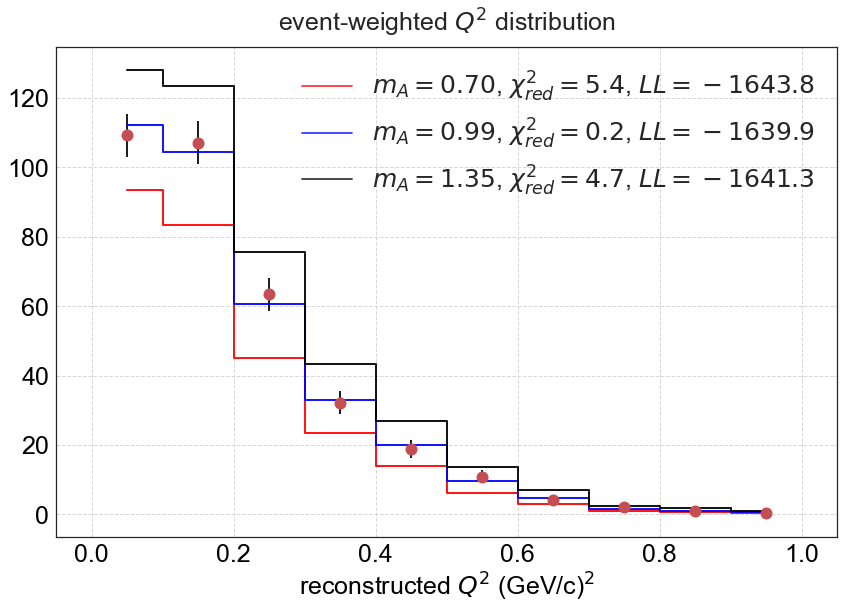

In [126]:
var = 'reco_Q2'
x_label = r'reconstructed $Q^2$ (GeV/c)$^2$'
bins = linspace(0,1,11); mid=0.5*(bins[1:]+bins[:-1])

fig,ax=plt.subplots(figsize=(14,9))
h_quasidata,edges = np.histogram(quasidata[var],bins=bins)
h_quasidata_err = np.sqrt(h_quasidata)*350./Nquasidata
h_quasidata = h_quasidata*350./Nquasidata
plt.errorbar(x=mid,y=h_quasidata,yerr=h_quasidata_err,fmt='ro',markersize=12,color='royalblue',ecolor='black')

for mA,name,color in zip([0.70,0.99,1.35]              
                         ,['070','099','135']
                         ,['red','blue','black']):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=selected_overlay
                           , ax=ax
                           , overlay_scaling=overlay_scalings['N(On) scaling and f(cosmic)=%.3f'%f_Cosmic]
                           , var=var, weights_var='evwgh_mA'+name+'_Genie'
                           , bins=bins
                           , do_individual_histograms=False
                           , stackColor=color,stackLabel=None)
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=(np.min(bins),np.max(bins))
                                         , h1=h_quasidata , h1err=h_quasidata_err
                                         , h2=h_overlay ,  h2err=h_overlay_err)
    
    
    LogLikelihood = LogLikelihood_histograms_data( histo = h_overlay, edges=edges
                                                  , data = np.array(quasidata[var])
                                                  , epsilon = 0.001 )


    h_overlay,_=plot_stacked_MCsamples( OverlaySamples=selected_overlay
                           , ax=ax
                           , overlay_scaling=overlay_scalings['N(On) scaling and f(cosmic)=%.3f'%f_Cosmic]
                           , var=var, weights_var='evwgh_mA'+name+'_Genie'
                           , bins=bins
                           , do_individual_histograms=False
                           , stackColor=color
                                       ,stackLabel=('$m_A=%.2f$'%mA
                                                    +', $\chi^2_{red}=%.1f$'%(chi2/ndf)
                                                    +', $LL=%.1f$'%LogLikelihood))
set_axes(ax,x_label,'',do_add_grid=False,alpha_grid=1
         ,do_add_legend=True
         ,title='event-weighted $Q^2$ distribution')